# Intro and Imports

In [112]:
import warnings
warnings.filterwarnings('ignore')

import re
import random
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.utils import shuffle
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, KFold, learning_curve

# Load the datasets
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

In [113]:
print(train_data.shape)
print(train_data.info())
print('\n')
print(test_data.shape)
print(test_data.info())

(175000, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           

# Preprocessing

In [114]:
# Replacing NaN with a default value in 'tpep_pickup_datetime' column
train_data['tpep_pickup_datetime'] = train_data['tpep_pickup_datetime'].fillna('')
test_data['tpep_pickup_datetime'] = test_data['tpep_pickup_datetime'].fillna('')

# Replacing NaN with a default value in 'tpep_dropoff_datetime' column
train_data['tpep_dropoff_datetime'] = train_data['tpep_dropoff_datetime'].fillna('')
test_data['tpep_dropoff_datetime'] = test_data['tpep_dropoff_datetime'].fillna('')

In [115]:
# Categorical Encoding
train_data = pd.get_dummies(train_data, columns=['store_and_fwd_flag', 'payment_type'])
test_data = pd.get_dummies(test_data, columns=['store_and_fwd_flag', 'payment_type'])

In [116]:
# Extracting Date-Time Features
train_data['pickup_hour'] = pd.to_datetime(train_data['tpep_pickup_datetime']).dt.hour
train_data['dropoff_hour'] = pd.to_datetime(train_data['tpep_dropoff_datetime']).dt.hour
test_data['pickup_hour'] = pd.to_datetime(test_data['tpep_pickup_datetime']).dt.hour
test_data['dropoff_hour'] = pd.to_datetime(test_data['tpep_dropoff_datetime']).dt.hour

train_data = train_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)
test_data = test_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [117]:
selected_columns = ['passenger_count', 'RatecodeID', 'congestion_surcharge', 'Airport_fee']

# Creating a new DataFrame containing only the selected columns
train_data_selected = train_data[selected_columns]
test_data_selected = test_data[selected_columns]

# Applying KNNImputer to the selected columns
imputer = KNNImputer(n_neighbors=5)
train_data_imputed = imputer.fit_transform(train_data_selected)
test_data_imputed = imputer.fit_transform(test_data_selected)

# Replacing the imputed values back into the original DataFrame
train_data[selected_columns] = train_data_imputed
test_data[selected_columns] = test_data_imputed

In [118]:
# Detecting missing values in train dataset
missing_values_count_train = train_data.isnull().sum()
print(missing_values_count_train)

print('\n')

# Detecting missing values in test dataset
missing_values_count_test = test_data.isnull().sum()
print(missing_values_count_test)

VendorID                    0
passenger_count             0
trip_distance               0
RatecodeID                  0
PULocationID                0
DOLocationID                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge        0
Airport_fee                 0
store_and_fwd_flag_N        0
store_and_fwd_flag_Y        0
payment_type_Cash           0
payment_type_Credit Card    0
payment_type_UPI            0
payment_type_Wallet         0
payment_type_unknown        0
pickup_hour                 0
dropoff_hour                0
dtype: int64


VendorID                    0
passenger_count             0
trip_distance               0
RatecodeID                  0
PULocationID                0
DOLocationID                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
congestion_surcharge     

# Baseline and Hyperparameter Tuning

In [119]:
X = train_data.drop('total_amount', axis=1)
y = train_data['total_amount']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [120]:
'''
# Linear Regression
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
linear_reg_predictions = linear_reg_model.predict(X_test)
r2_linear_reg = r2_score(y_test, linear_reg_predictions)
print(f"Linear Regression R^2 Score: {r2_linear_reg}")

# Random Forest Regression
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=0)
random_forest_model.fit(X_train, y_train)
random_forest_predictions = random_forest_model.predict(X_test)
r2_random_forest = r2_score(y_test, random_forest_predictions)
print(f"Random Forest Regression R^2 Score: {r2_random_forest}")

# XGBoost Regression
xgb_model = xgb.XGBRegressor(n_estimators=222, random_state=0)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, xgb_predictions)
print(f"XGBoost Regression R^2 Score: {r2_xgb}")

# Gradient Boosting Regression
gbm_model = GradientBoostingRegressor(n_estimators=222)
gbm_model.fit(X_train, y_train)
predictions = gbm_model.predict(X_test)
r2_gbm = r2_score(y_test, predictions)
print(f"Gradient Boosting Regression R^2 Score on Test Data: {r2_gbm}")
'''

'\n# Linear Regression\nlinear_reg_model = LinearRegression()\nlinear_reg_model.fit(X_train, y_train)\nlinear_reg_predictions = linear_reg_model.predict(X_test)\nr2_linear_reg = r2_score(y_test, linear_reg_predictions)\nprint(f"Linear Regression R^2 Score: {r2_linear_reg}")\n\n# Random Forest Regression\nrandom_forest_model = RandomForestRegressor(n_estimators=100, random_state=0)\nrandom_forest_model.fit(X_train, y_train)\nrandom_forest_predictions = random_forest_model.predict(X_test)\nr2_random_forest = r2_score(y_test, random_forest_predictions)\nprint(f"Random Forest Regression R^2 Score: {r2_random_forest}")\n\n# XGBoost Regression\nxgb_model = xgb.XGBRegressor(n_estimators=222, random_state=0)\nxgb_model.fit(X_train, y_train)\nxgb_predictions = xgb_model.predict(X_test)\nr2_xgb = r2_score(y_test, xgb_predictions)\nprint(f"XGBoost Regression R^2 Score: {r2_xgb}")\n\n# Gradient Boosting Regression\ngbm_model = GradientBoostingRegressor(n_estimators=222)\ngbm_model.fit(X_train, y_t

In [121]:
'''
# Parameter Grid to Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Random Forest Regressor Model
random_forest_model = RandomForestRegressor(random_state=0)

# R^2 score as the scoring metric for Randomized Search
r2_scorer = make_scorer(r2_score)

# Randomized Search with K-Fold Cross-Validation
random_search = RandomizedSearchCV(estimator=random_forest_model, param_distributions=param_dist,
                                   scoring=r2_scorer, cv=kfold, n_jobs=-1, n_iter=100, random_state=0)
random_search.fit(X_train, y_train)

# Best parameters and the corresponding R^2 score
print("Best Parameters: ", random_search.best_params_)
print("Best R^2 Score: {:.2f}".format(random_search.best_score_))

# Extracting the best parameters
best_params = random_search.best_params_

# Random Forest Regressor with the best parameters
best_random_forest_model = RandomForestRegressor(**best_params, random_state=0)

# Training the model on the training data
best_random_forest_model.fit(X_train, y_train)

# Making predictions on the test data
predictions = best_random_forest_model.predict(X_test)

# Calculating R^2 score on the test data
r2_random_forest = r2_score(y_test, predictions)
print(f"Random Forest Regression R^2 Score on Test Data: {r2_random_forest}")
'''

'\n# Parameter Grid to Search\nparam_dist = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'auto\', \'sqrt\']\n}\n\n# K-Fold Cross-Validation\nkfold = KFold(n_splits=5, shuffle=True, random_state=0)\n\n# Random Forest Regressor Model\nrandom_forest_model = RandomForestRegressor(random_state=0)\n\n# R^2 score as the scoring metric for Randomized Search\nr2_scorer = make_scorer(r2_score)\n\n# Randomized Search with K-Fold Cross-Validation\nrandom_search = RandomizedSearchCV(estimator=random_forest_model, param_distributions=param_dist,\n                                   scoring=r2_scorer, cv=kfold, n_jobs=-1, n_iter=100, random_state=0)\nrandom_search.fit(X_train, y_train)\n\n# Best parameters and the corresponding R^2 score\nprint("Best Parameters: ", random_search.best_params_)\nprint("Best R^2 Score: {:.2f}".format(random_search.best_score_))\n\n# Extr

# ML Model

In [122]:
# Random Forest Regression
random_forest_model = RandomForestRegressor(n_estimators=222, random_state=42)
random_forest_model.fit(X_train, y_train)
random_forest_predictions = random_forest_model.predict(X_test)
r2_random_forest = r2_score(y_test, random_forest_predictions)
print(f"Random Forest Regression R^2 Score: {r2_random_forest}")

Random Forest Regression R^2 Score: 0.9624009422688035


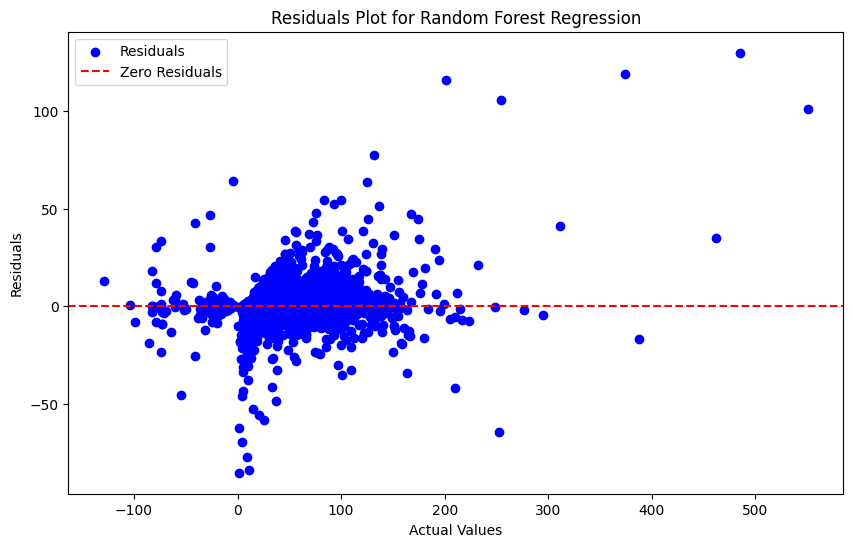

In [123]:
# Residuals Plot
plt.figure(figsize=(10, 6))
residuals = y_test - random_forest_predictions
plt.scatter(y_test, residuals, color='blue', label='Residuals')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals')
plt.title('Residuals Plot for Random Forest Regression')
plt.legend()
plt.show()

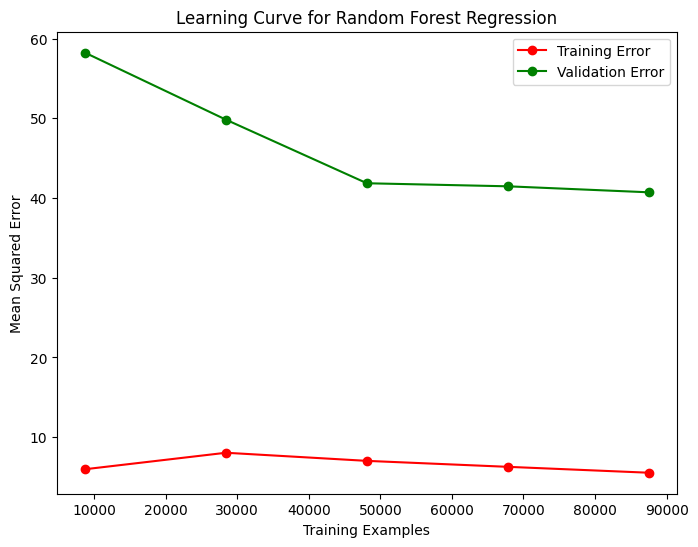

In [124]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(random_forest_model, X, y, cv=2, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation Error')
plt.xlabel('Training Examples')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve for Random Forest Regression')
plt.legend()
plt.show()

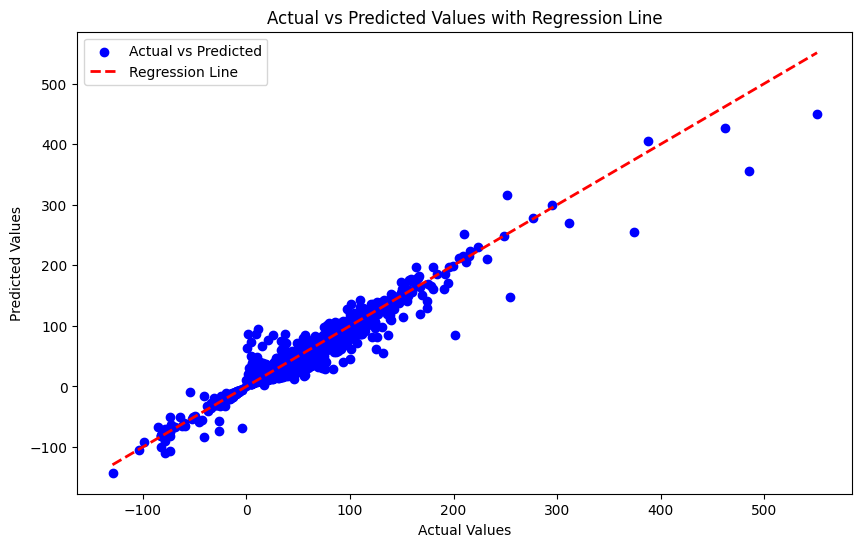

In [125]:
# Regression Line Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, random_forest_predictions, color='blue', label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Regression Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with Regression Line')
plt.legend()
plt.show()

# Submission

In [129]:
X = train_data.drop('total_amount', axis=1)
y = train_data['total_amount']
X_test = test_data

# Random Forest Regression Model
model = RandomForestRegressor(n_estimators=222, random_state=42)
model.fit(X, y)
predictions = model.predict(X_test)

# Creating submission
ids = range(1, len(test_data) + 1)
submission_df = pd.DataFrame({'ID': ids, 'total_amount': predictions})

# Saving the predictions to a CSV file
submission_df.to_csv('submission.csv', index=False)

print(len(ids))  # Checking the length of IDs array
print(len(predictions))  # Checking the length of predictions array

50000
50000
